In [19]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from minisom import MiniSom
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from itertools import product
import itertools
from sammon import sammon

In [4]:
dataset = xr.open_dataarray('data/Z500FiltAnoms_ERA5_v3.nc')

latSlice = slice(20, 80) #20N, 80N
lonSlice = slice(200, 310) #160W, 50W
dataarray = dataset.sel(lat=latSlice, lon=lonSlice)
dataarray = dataarray.stack(latlon=['lat', 'lon']).values

print(dataarray.shape)

(30681, 6771)


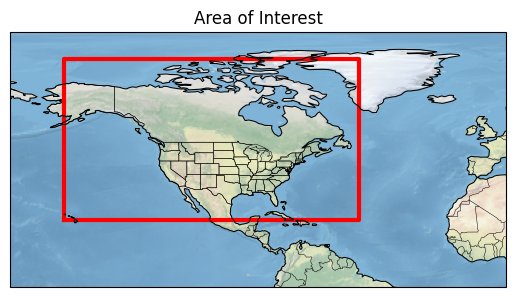

In [3]:
fig = plt.figure()
proj = ccrs.PlateCarree()
ax = plt.axes(projection=proj)

ax.set_extent((-180, 5, -5, 90), crs=proj)
ax.stock_img()
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

plt.plot([200, 310, 310, 200, 200], [20, 20, 80, 80, 20], color='r', linewidth=3, transform=proj)
plt.title('Area of Interest')
plt.show()

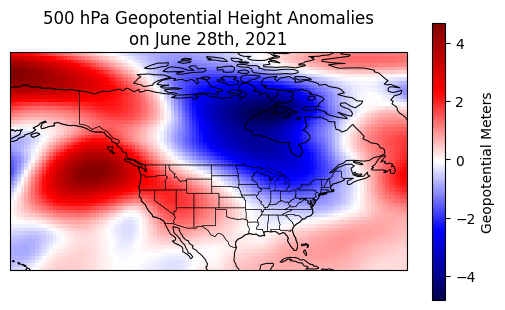

In [5]:
day = '2021-06-20'
day = dataset.sel(time=day, lat=latSlice, lon=lonSlice).values
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
im = ax.pcolormesh(lons, lats, day, cmap='seismic', transform=ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
fig.colorbar(im, shrink=.75, label='Geopotential Meters')
plt.title('500 hPa Geopotential Height Anomalies\non June 28th, 2021')
plt.show()

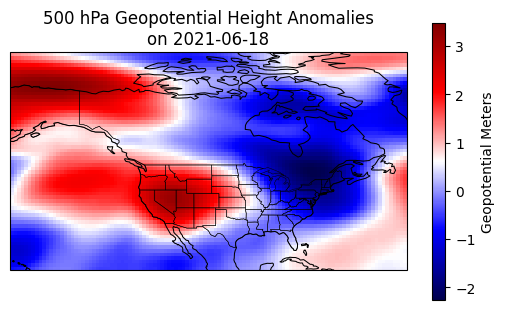

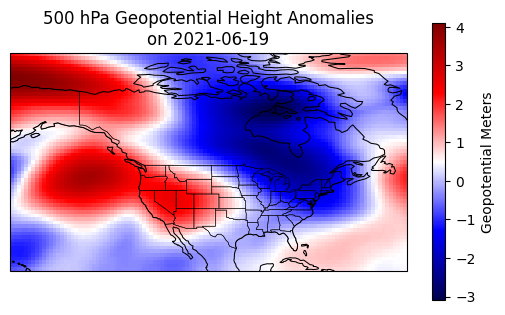

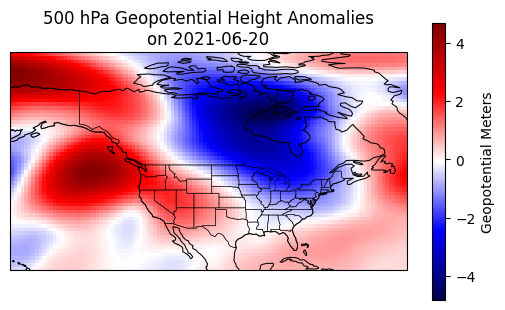

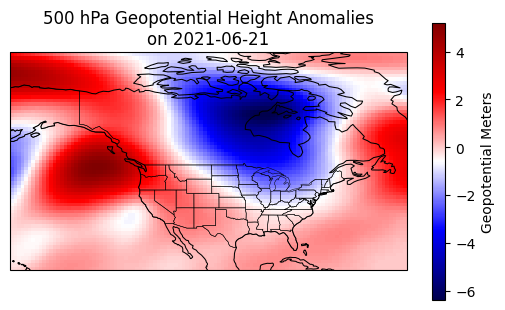

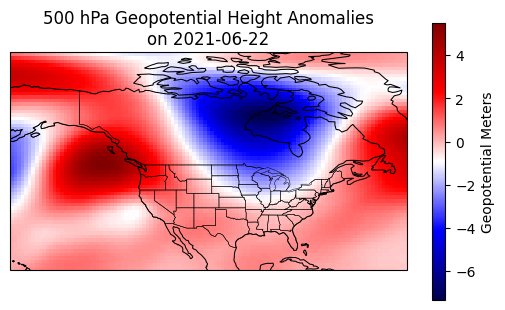

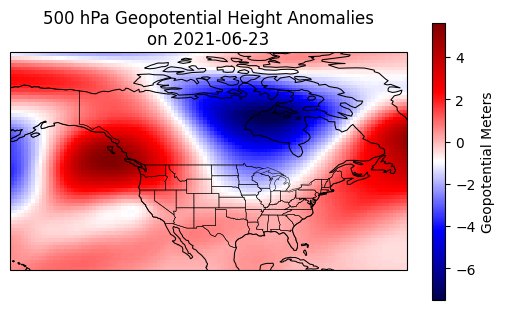

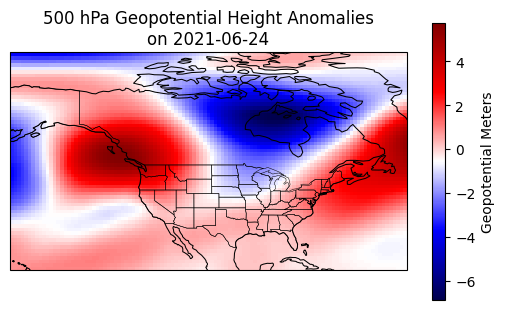

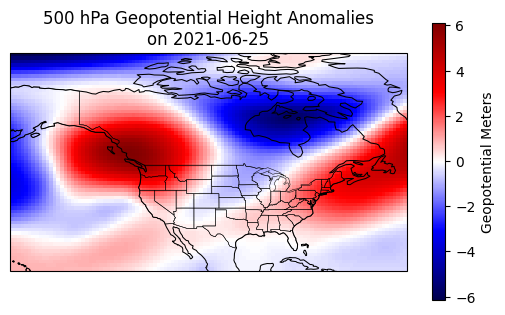

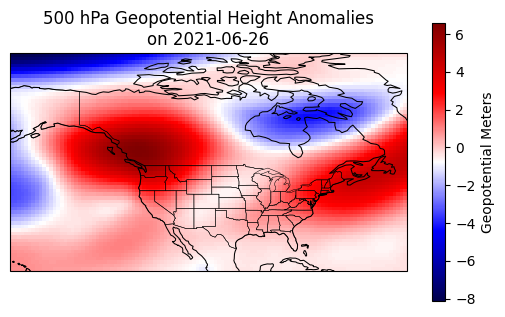

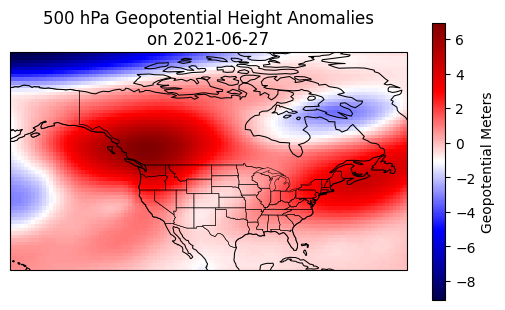

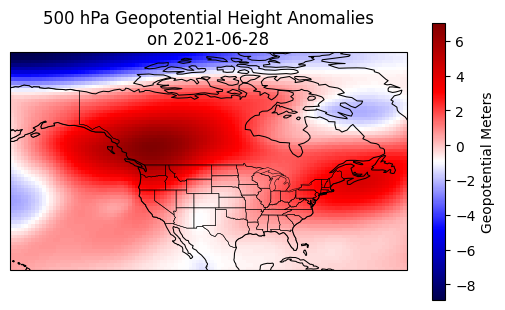

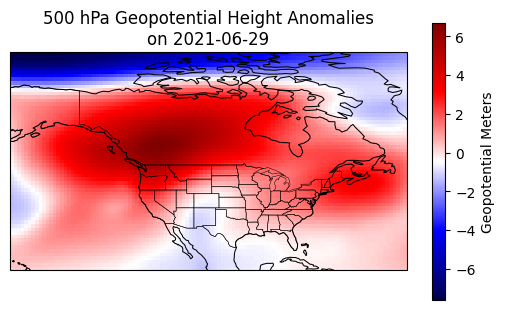

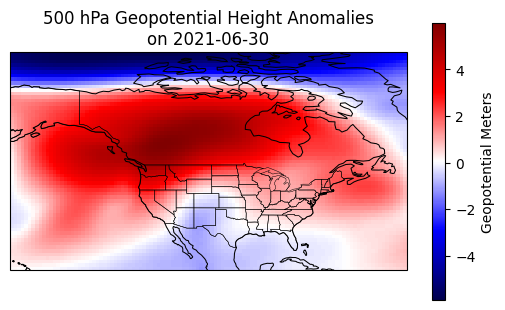

In [6]:
lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
lons = dataset.sel(lat=latSlice, lon=lonSlice).lon
days = ['2021-06-18', '2021-06-19','2021-06-20', '2021-06-21', '2021-06-22',
        '2021-06-23','2021-06-24','2021-06-25', '2021-06-26', '2021-06-27', 
        '2021-06-28', '2021-06-29','2021-06-30']


artists = []

for day in days:
    data = dataset.sel(time=day, lat=latSlice, lon=lonSlice).values

    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
    im = ax.pcolormesh(lons, lats, data, cmap='seismic', transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
    ax.add_feature(cf.BORDERS, linewidth=0.35, zorder=10)
    fig.colorbar(im, shrink=.75, label='Geopotential Meters')
    plt.title(f'500 hPa Geopotential Height Anomalies\non {day}')
    plt.savefig(f'animation/{day}.png')

plt.show()

In [3]:
def pca_weights(som, data):
    if som._input_len == 1:
        msg = 'The data needs at least 2 features for pca initialization'
        raise ValueError(msg)
    som._check_input_len(data)
    if len(som._neigx) == 1 or len(som._neigy) == 1:
        msg = 'PCA initialization inappropriate:' + \
                'One of the dimensions of the map is 1.'

    pc_length, eigvecs = np.linalg.eig(np.cov(data))
    print(pc_length)
    print(eigvecs.T)
    pc = (eigvecs.T @ data)
    print(pc)
    pc_order = np.argsort(-pc_length)
    print(pc_order)
    for i, c1 in enumerate(np.linspace(-1, 1, len(som._neigx))):
        for j, c2 in enumerate(np.linspace(-1, 1, len(som._neigy))):
            print(c1*pc[pc_order[0]] + c2*pc[pc_order[1]])
            som._weights[i, j] = c1*pc[pc_order[0]] + \
                                    c2*pc[pc_order[1]]

In [135]:
row_neurons = 5
col_neurons = 5
inputLength = dataarray.shape[1]
sigma = 3.5
learning_rate = .001
decay_function = 'asymptotic_decay'
neighborhood_function = 'gaussian'
topology = 'hexagonal'
random_seed = 28

# TRAINING
hexsom = MiniSom(row_neurons, col_neurons, inputLength, sigma=sigma, learning_rate=learning_rate, 
                 neighborhood_function=neighborhood_function, decay_function=decay_function, random_seed=random_seed, topology=topology)
hexsom.random_weights_init(dataarray)
hexsom.train(dataarray, 200000, random_order=True)

In [136]:
def hex_heatmap(som, data, cmap='Blues', title='', cbLabel=''):
    # set up the figure
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    cmap = mpl.colormaps[cmap]
    
    # get data from the som
    weights = som.get_weights()
    xx, yy = som.get_euclidean_coordinates()
    
    maxCount = max(v for v in data.values())
    minCount = min(v for v in data.values())
    
    # loops through the neurons
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            # If theres no data still plot the hexagon
            if (i, j) not in data:
                data[(i,j)] = 0
                
            # determine the hexagon position and color
            wx = xx[(i, j)]
            wy = yy[(i, j)] * np.sqrt(3) / 2
            colorWeight = data[(i, j)]/maxCount
            
            # Create hexagon and add it to axis
            hex = patches.RegularPolygon((wx, wy), numVertices=6, radius=.85 / np.sqrt(3), 
                                    facecolor=cmap(colorWeight), edgecolor='grey')
            ax.add_patch(hex)
            
            # determine the color the text should be based on color of node
            if colorWeight >= .7:
                textColor = 'white'
            else:
                textColor = 'black'
            
            # add text to hexagon for its frequency
            plt.text(wx, wy-.05, f'{data[(i, j)]}', {'horizontalalignment': 'center', 'color': textColor, 'fontsize': 15})
            
    # align figure to show all hexagons
    plt.xlim(-1, weights.shape[0] - .5)
    plt.ylim(-1, (weights.shape[1] - .5) * np.sqrt(3) / 2)
    
    # remove the axis labels and lines
    ax.axis('off')
    #plt.gca().invert_yaxis()
    
    # Create the color bar
    norm = mpl.colors.Normalize(vmin=minCount, vmax=maxCount)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, shrink=.7)
    cb.set_label(label=cbLabel, size=13)
    
    # Title the plot
    plt.title(title, fontsize=20)
    
    return fig

def hex_plot(x_neurons, y_neurons, projection=None):
    """Create a matplot lib figure with an axis for each neuron already positioned into the hexagonal shape"""
    
    # create figure
    totRows = x_neurons * 3
    totCols = y_neurons * 2
    fig = plt.figure(figsize=[totRows, totCols])
    axs = {}
    
    for x, y in list(product(range(x_neurons), range(y_neurons))):
        # odd rows will be offset to keep the hexagonal shape
        if y % 2 == 0:
            curRow = x * 3
        else:
            curRow = (x * 3) + 1
            
        curCol = (totCols - 2) - (y * 2)

        ax = plt.subplot2grid((totCols, totRows), (curCol, curRow), rowspan=2, colspan=2, projection=projection)
        ax.set_title((x, y))
        axs[(x, y)] = ax
        
    return fig, axs

def hex_composite_map(som, winmap=None):
    fig, axs = hex_plot(5, 5, projection=ccrs.PlateCarree())

    lats = dataset.sel(lat=latSlice, lon=lonSlice).lat
    lons = dataset.sel(lat=latSlice, lon=lonSlice).lon
    lons, lats = np.meshgrid(lons, lats)
    
    if winmap == None:
        winmap = som.win_map(dataarray, return_indices=True)
    neurons = list(winmap.keys())

    # calculate the average of eacah of the nodes
    #if somAvgs == None:
        #somAvgs = {neuron: [] for neuron in neurons}
        #for i in range(len(neurons)):
            #somAvgs[neurons[i]] = dataset[winmap[neurons[i]]].mean(dim='time', skipna=True)      
    w = som._weights

    for neuron in neurons:
        avgs = np.array(w[neuron[0], neuron[1], :]).reshape((lons.shape[0], lats.shape[1]))

        axs[neuron[1], neuron[0]].pcolor(lons, lats, avgs, cmap='seismic', shading='nearest', transform=ccrs.PlateCarree())
        
        axs[neuron[1], neuron[0]].set_title(f"Sample size: {len(winmap[(neuron[0], neuron[1])])}: {(neuron[0], neuron[1])})", fontsize=12)
        
        # background map features
        axs[neuron[1], neuron[0]].coastlines(resolution='110m', color='k', linewidth=0.75, zorder=10)
        axs[neuron[1], neuron[0]].margins(x=0, y=0)
        axs[neuron[1], neuron[0]].add_feature(cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
        axs[neuron[1], neuron[0]].add_feature(cf.BORDERS, linewidth=0.35, zorder=10)

    return fig

In [137]:
winmap = hexsom.win_map(dataarray, return_indices=True)

In [138]:
#wincount = hexsom.activation_response(dataarray)

In [139]:
#print(wincount)
print(hexsom._xx)
print(hexsom._yy)

[[-0.5  0.5  1.5  2.5  3.5]
 [ 0.   1.   2.   3.   4. ]
 [-0.5  0.5  1.5  2.5  3.5]
 [ 0.   1.   2.   3.   4. ]
 [-0.5  0.5  1.5  2.5  3.5]]
[[0.         0.         0.         0.         0.        ]
 [0.8660254  0.8660254  0.8660254  0.8660254  0.8660254 ]
 [1.73205081 1.73205081 1.73205081 1.73205081 1.73205081]
 [2.59807621 2.59807621 2.59807621 2.59807621 2.59807621]
 [3.46410162 3.46410162 3.46410162 3.46410162 3.46410162]]


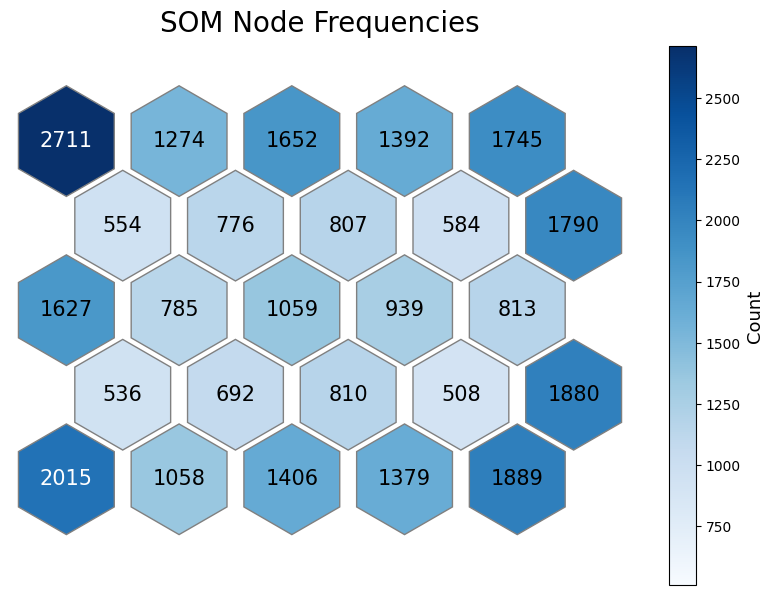

In [140]:
data = {k: len(v) for k, v in winmap.items()}
    
fig = hex_heatmap(hexsom, data, 'Blues', 'SOM Node Frequencies', 'Count')
plt.show()

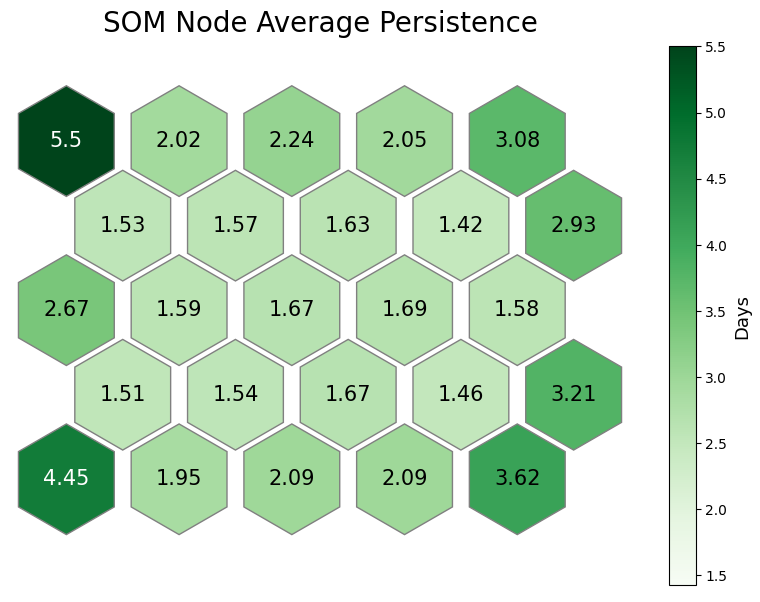

In [141]:
# Determine how consistant each weather regime is
regimePersistences = {}

for neuron in winmap:
    idxs = np.array(winmap[neuron])
    
    persistencesList = []
    diffs = np.diff(idxs)
    groups = np.split(diffs, np.where(diffs != 1)[0]+1)
    persistencesList = [len(l) for l in groups]
    persistencesList[-1] += 1
    numDays, count = np.unique(persistencesList, return_counts=True)
    #count = count / sum(count)
    
    regimePersistences[neuron] = (numDays, count)

# Caluculate the average persistence for each node
averagePersistences = {k: round(sum(v[0] * v[1]) / sum(v[1]), 2) for k, v in regimePersistences.items()}

fig = hex_heatmap(hexsom, averagePersistences, 'Greens', 'SOM Node Average Persistence', 'Days')
plt.show()

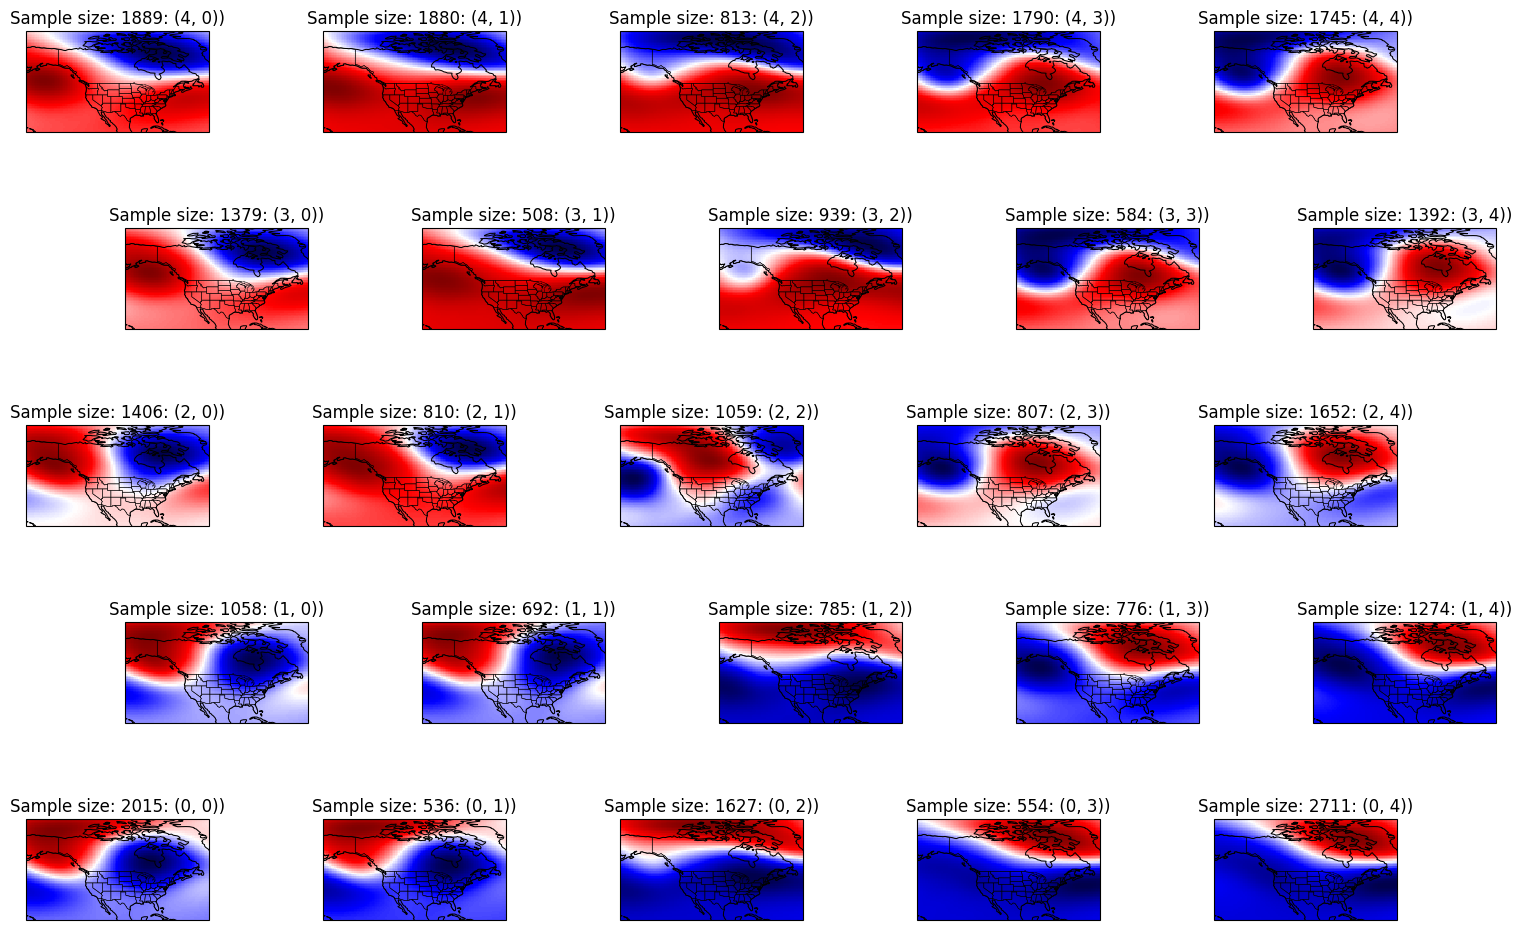

In [142]:
fig = hex_composite_map(hexsom, winmap=winmap)
fig.tight_layout()
plt.show()

3.09978787524844e-05


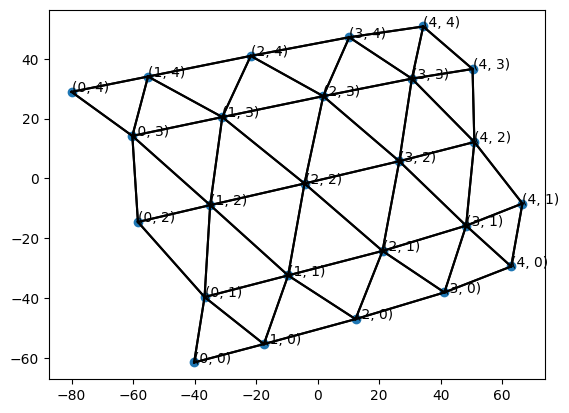

In [143]:
neurons = list(product(range(5), range(5)))

# Find the edges between nodes
edgeCoordinates = []
for i, neuron in enumerate(neurons):
    x, y = neuron
    adj = [(x-1, y), (x+1, y), (x,y-1), (x,y+1)]
    
    if neuron[1] % 2 == 0:
        adj.append((x-1, y+1))
        adj.append((x-1, y-1))
        
    else:
        adj.append((x+1, y+1))
        adj.append((x+1, y-1))
    
    adj = [(i, neurons.index((x, y))) for x, y in adj if x >= 0 and x <= max(neurons)[0] and y >= 0 and y <= max(neurons)[1]]
    edgeCoordinates.extend(adj)
    
weights = hexsom.get_weights().reshape(col_neurons*row_neurons, inputLength)

climatology = [0] * inputLength

# Run the Sammon projection
[y,E] = sammon.sammon(weights, 2, display=1)
#y1 = np.append(y, climatology, axis=0)
#print(y1[-1, :])
print(E)

# Plot the centers of the nodes
plt.scatter(y[:, 0], y[:, 1])

for s, e in edgeCoordinates:
    plt.plot(y[[s,e], 0], y[[s,e], 1], color='black')

# Label the Nodes
for i, n in enumerate(neurons):
    plt.annotate(str(n), (y[i, 0], y[i, 1]))
    
#plt.annotate('Climatology', (y[-1, 0], y[-1, 1]), horizontalalignment='center')
plt.show()

In [125]:
print(neurons)

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]
